# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


# Unzip Data

In [ ]:
!unzip 'drive/MyDrive/Projects/train.zip'

Archive:  drive/MyDrive/Projects/train.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Train/0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
n


In [ ]:
!pip install resampy==0.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320704 sha256=d17723c77c46a77c8cbaf472cb3449377615bc27998369aa0479cd8c9985b404
  Stored in directory: /root/.cache/pip/wheels/e5/a0/79/29e61754e5b3941ad4c7d01bf5bea99768e64e4bdd3180f32b
Successfully built resampy


# Importing Modules

In [ ]:
import pandas as pd
import numpy as np
import librosa
import resampy
import librosa.display
import glob
import IPython.display as ipd
import random
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
import warnings
import os
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Loading the Dataset

In [ ]:
df = pd.read_csv('/content/Urban Sound Dataset.csv')
df.head()

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


### Checking for Null values

In [ ]:
print(df.isnull().values.any())

False


In [ ]:
ipd.Audio('Train/123.wav')

# Exploratory Data Analysis

In [ ]:
data, sampling_rate = librosa.load('Train/1.wav')

In [ ]:
print("Data :",data)
print("Sampling Rate :",sampling_rate)

Data : [-0.09316424 -0.14310586  0.05254411 ... -0.01574724 -0.0098122
  0.09794901]
Sampling Rate : 22050


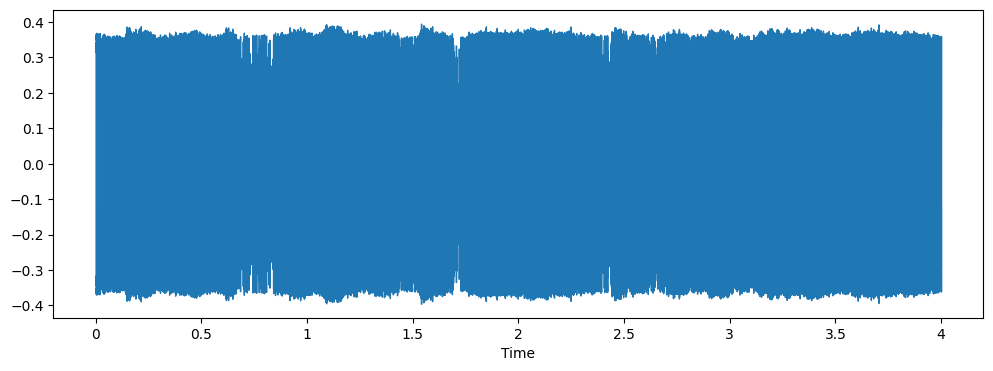

In [ ]:
plt.figure(figsize=(12,4))
librosa.display.waveshow(data, sr=sampling_rate)

Class : jackhammer


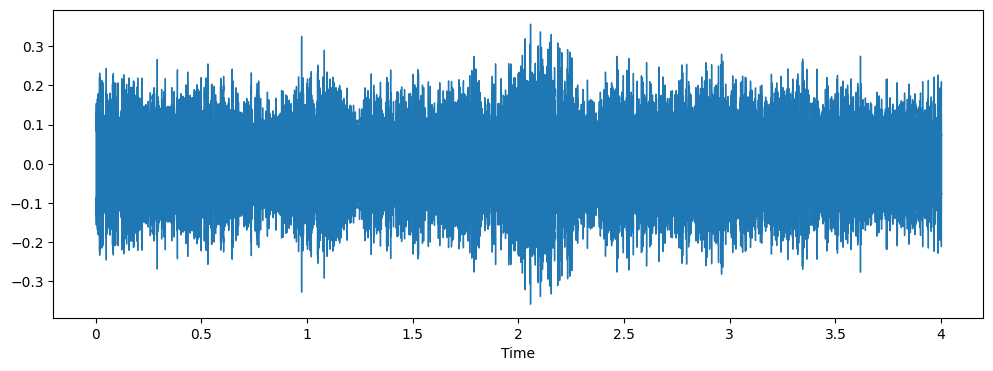

In [ ]:
i = random.choice(df.index)
print('Class :', df['Class'][i])
data, sampling_rate = librosa.load('Train/'+str(df['ID'][i])+'.wav')
plt.figure(figsize=(12,4))
librosa.display.waveshow(data, sr=sampling_rate)

Class : car_horn


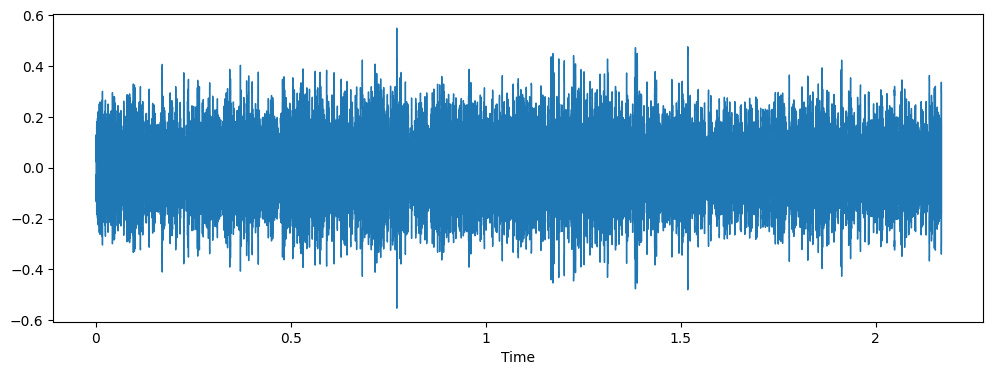

In [ ]:
i = random.choice(df.index)
print('Class :', df['Class'][i])
data, sampling_rate = librosa.load('Train/'+str(df['ID'][i])+'.wav')
plt.figure(figsize=(12,4))
librosa.display.waveshow(data, sr=sampling_rate)

<Axes: xlabel='Class', ylabel='count'>

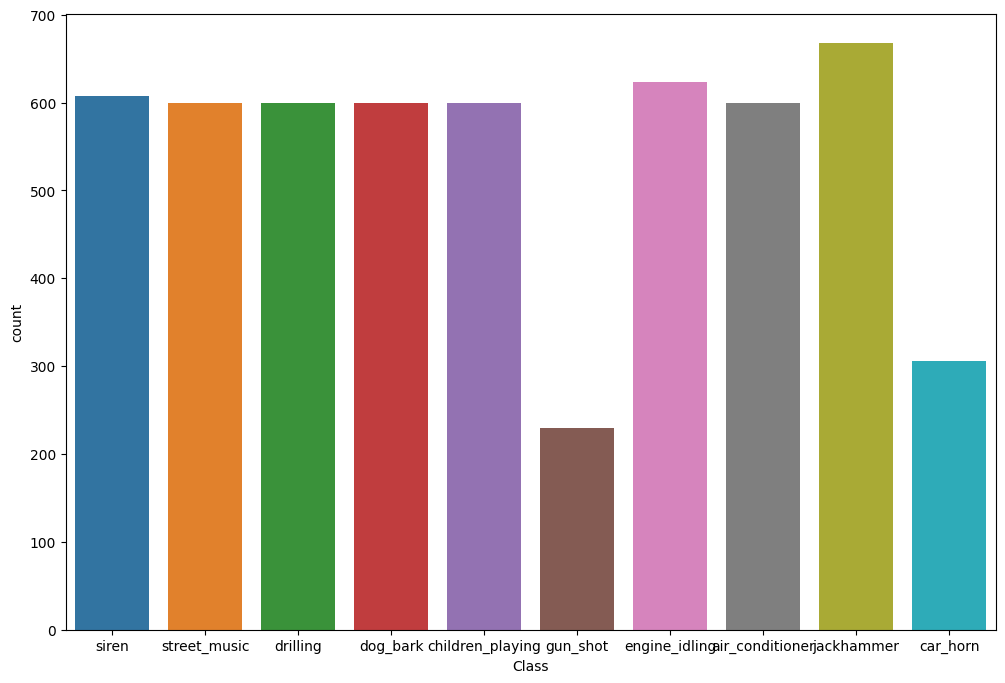

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(hue='Class',data=df,x='Class')

# Splitting Input

In [ ]:
def parser(row):
  file_name = os.path.join('Train',str(row.ID)+'.wav')
  data, sampling_rate = librosa.load(file_name, res_type='kaiser_fast')
  mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40).T,axis=0)
  feature = mfccs
  label = row.Class
  return [feature,label]

In [ ]:
data = df.apply(parser,axis=1)
data = pd.DataFrame(data.tolist(), columns=['feature', 'label'])

In [ ]:
data.iloc[0]

,0
feature,"[-82.44282, 139.54434, -42.461792, 24.845692, ..."
label,siren


In [ ]:
X = np.array(data['feature'].tolist())
y = np.array(data['label'].tolist())

# Label Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.utils import to_categorical

le = LabelEncoder()
m = to_categorical(le.fit_transform(y))

In [ ]:
m.shape

(5435, 10)

In [ ]:
m[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

# Creating the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam

num_classes = 10

model = Sequential()
model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 256)                 │          10,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 10)                  │           5,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 147,210 (575.04 KB)

 Trainable params: 147,210 (575.04 KB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [ ]:
model.fit(X,m, batch_size=32, epochs=100, validation_split=0.25)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3912 - loss: 2.0395 - val_accuracy: 0.5835 - val_loss: 1.3048
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5192 - loss: 1.3985 - val_accuracy: 0.6284 - val_loss: 1.1410
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6088 - loss: 1.1629 - val_accuracy: 0.6895 - val_loss: 1.0014
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6434 - loss: 1.0462 - val_accuracy: 0.7233 - val_loss: 0.8791
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6905 - loss: 0.9242 - val_accuracy: 0.7550 - val_loss: 0.8094
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7119 - loss: 0.8416 - val_accuracy: 0.7660 - val_loss: 0.7627
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7442 - loss: 0.7460 - val_accuracy: 0.7645 - val_loss: 0.7021
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7759 - loss: 0.6657 - val_ac

# Prediction

In [ ]:
!unzip 'drive/MyDrive/Projects/test.zip'

Archive:  drive/MyDrive/Projects/test.zip
   creating: Test/
  inflating: test.csv                
  inflating: Test/1002.wav           
  inflating: Test/1005.wav           
  inflating: Test/1009.wav           
  inflating: Test/1010.wav           
  inflating: Test/1011.wav           
  inflating: Test/1012.wav           
  inflating: Test/1013.wav           
  inflating: Test/1016.wav           
  inflating: Test/1019.wav           
  inflating: Test/102.wav            
  inflating: Test/1020.wav           
  inflating: Test/1023.wav           
  inflating: Test/1031.wav           
  inflating: Test/1033.wav           
  inflating: Test/1035.wav           
  inflating: Test/1037.wav           
  inflating: Test/1039.wav           
  inflating: Test/1041.wav           
  inflating: Test/1046.wav           
  inflating: Test/1050.wav           
  inflating: Test/1053.wav           
  inflating: Test/1057.wav           
  inflating: Test/106.wav            
  inflating: Test/1060.wav 

In [ ]:
def extract_mfcc(file_path):
    data, sampling_rate = librosa.load(file_path, res_type='kaiser_fast', duration=3)
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40).T, axis=0)
    return mfccs

def predict_class(file_path, model):
    mfcc_features = extract_mfcc(file_path)
    mfcc_features = np.reshape(mfcc_features, (1, 40))
    predictions = model.predict(mfcc_features)
    predicted_class_idx = np.argmax(predictions)

    return predicted_class_idx

new_audio_file = "Test/8319.wav"
predicted_class_idx = predict_class(new_audio_file, model)
le = LabelEncoder()
le.fit(y)

predicted_class_label = le.inverse_transform([predicted_class_idx])[0]  # Decode the class index
print(f"The predicted class for the audio file is: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
The predicted class for the audio file is: dog_bark


In [ ]:
ipd.Audio('Test/8319.wav')